# 04 — Feature Engineering

**Goal:** Build position-specific feature sets on top of the cleaned merged data.

**Inputs:** `../data/processed/merged_*.csv`

**Outputs:** `../data/processed/featured_*.csv` · `../data/processed/feature_sets.json` · `../figures/04_*.png`

**Next:** `05_preprocessing.ipynb`

---
**Design decisions:**
- Clean sheets already computed in notebook 03 — not recomputed here
- Per-90 rates are the primary signal (normalise for playing time differences)
- Log transforms on skewed counts (`total_minutes`, `total_appearances`, `highest_market_value_in_eur`, `total_fees_eur`)
- `red_per_90` computed but excluded from feature sets (EDA: median=0, near-zero signal)
- `current_club_domestic_competition_id` kept as categorical — encoded in notebook 05
- All engineered features capped at 99th percentile after creation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import warnings
warnings.filterwarnings('ignore')

sns_available = False
try:
    import seaborn as sns
    sns.set_theme(style='whitegrid', palette='muted')
    sns_available = True
except ImportError:
    pass

plt.rcParams['figure.dpi'] = 100

PROC_PATH    = '../data/processed/'
MERGED_PATH  = '../data/processed/merged/'
FEAT_PATH    = '../data/processed/featured/'
FIGURES_PATH = '../figures/'
os.makedirs(FEAT_PATH,    exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

print('Paths OK')

## 1. Load Processed Data

In [ ]:
df_gk  = pd.read_csv(MERGED_PATH + 'merged_gk.csv')
df_def = pd.read_csv(MERGED_PATH + 'merged_def.csv')
df_mid = pd.read_csv(MERGED_PATH + 'merged_mid.csv')
df_att = pd.read_csv(MERGED_PATH + 'merged_att.csv')

print('Loaded position groups:')
for label, df in [('GK', df_gk), ('DEF', df_def), ('MID', df_mid), ('ATT', df_att)]:
    n_val = df['market_value_in_eur'].notna().sum()
    print(f'  {label}: {len(df):>6,} players  ({n_val:,} with valuation)  {df.shape[1]} columns')

print(f'\nColumns in: {df_gk.columns.tolist()}')

## 2. Base Features — Shared Across All Positions

In [19]:
def add_base_features(df):
    df = df.copy()

    # Safe denominators — avoid division by zero
    safe_min = df['total_minutes'].replace(0, np.nan)
    safe_app = df['total_appearances'].replace(0, np.nan)

    # --- Per-90 rate stats ---
    df['goals_per_90']        = (df['total_goals']   / safe_min * 90).fillna(0)
    df['assists_per_90']      = (df['total_assists']  / safe_min * 90).fillna(0)
    df['contributions_per_90']= df['goals_per_90'] + df['assists_per_90']
    df['yellow_per_90']       = (df['total_yellow']   / safe_min * 90).fillna(0)
    df['red_per_90']          = (df['total_red']      / safe_min * 90).fillna(0)  # excluded from feature sets
    df['clean_sheets_per_90'] = (df['clean_sheets']   / safe_min * 90).fillna(0)

    # --- Experience (log-scaled to reduce skew) ---
    df['log_minutes']     = np.log1p(df['total_minutes'])
    df['log_appearances'] = np.log1p(df['total_appearances'])
    df['age_squared']     = df['age'] ** 2

    # --- Value history & transfer signals ---
    df['log_highest_mv']  = np.log1p(df['highest_market_value_in_eur'])
    df['log_total_fees']  = np.log1p(df['total_fees_eur'])

    return df

df_gk  = add_base_features(df_gk)
df_def = add_base_features(df_def)
df_mid = add_base_features(df_mid)
df_att = add_base_features(df_att)

print('Base features added to all position groups.')
print(f'New columns: {[c for c in df_gk.columns if c not in pd.read_csv(PROC_PATH+"merged_gk.csv").columns]}')

Base features added to all position groups.
New columns: ['goals_per_90', 'assists_per_90', 'contributions_per_90', 'yellow_per_90', 'red_per_90', 'clean_sheets_per_90', 'log_minutes', 'log_appearances', 'age_squared', 'log_highest_mv', 'log_total_fees', 'cs_rate', 'save_pct_proxy', 'gk_offensive']


## 3. Goalkeeper Features

In [18]:
def add_gk_features(df):
    df = df.copy()
    safe_app = df['total_appearances'].replace(0, np.nan)

    # Primary GK metric: clean sheet rate per appearance
    df['cs_rate']          = (df['clean_sheets'] / safe_app).fillna(0)

    # Save % proxy: derived from clean_sheets_per_90 (higher = fewer goals conceded)
    df['save_pct_proxy']   = df['clean_sheets_per_90']

    # Modern GK offensive contribution (rare but signals quality)
    df['gk_offensive']     = df['contributions_per_90']

    return df

df_gk = add_gk_features(df_gk)
print('GK features added.')
print(f'  cs_rate mean:        {df_gk["cs_rate"].mean():.3f}')
print(f'  save_pct_proxy mean: {df_gk["save_pct_proxy"].mean():.3f}')

GK features added.
  cs_rate mean:        0.293
  save_pct_proxy mean: 0.359


## 4. Defender Features

In [17]:
def add_def_features(df):
    df = df.copy()
    safe_app = df['total_appearances'].replace(0, np.nan)

    # Clean sheet contribution
    df['def_cs_rate']          = (df['clean_sheets'] / safe_app).fillna(0)
    df['defensive_solidity']   = df['clean_sheets_per_90']

    # Offensive output from defence (signals modern, ball-playing defenders)
    df['def_attack_per_90']    = df['contributions_per_90']

    # Discipline: yellow + 3× red (red is more costly)
    df['discipline_score']     = df['yellow_per_90'] + df['red_per_90'] * 3

    return df

df_def = add_def_features(df_def)
print('DEF features added.')
print(f'  def_cs_rate mean:       {df_def["def_cs_rate"].mean():.3f}')
print(f'  def_attack_per_90 mean: {df_def["def_attack_per_90"].mean():.3f}')
print(f'  discipline_score mean:  {df_def["discipline_score"].mean():.3f}')

DEF features added.
  def_cs_rate mean:       0.125
  def_attack_per_90 mean: 0.059
  discipline_score mean:  0.175


## 5. Midfielder Features

In [16]:
def add_mid_features(df):
    df = df.copy()

    # Creativity — assists are the key midfielder signal
    df['creative_per_90']      = df['assists_per_90']

    # Total attacking output
    df['mid_attack_per_90']    = df['contributions_per_90']

    # Attack/defence balance: high means creative and disciplined
    df['attack_defense_ratio'] = df['contributions_per_90'] / (df['yellow_per_90'] + 0.01)

    return df

df_mid = add_mid_features(df_mid)
print('MID features added.')
print(f'  creative_per_90 mean:      {df_mid["creative_per_90"].mean():.3f}')
print(f'  attack_defense_ratio mean: {df_mid["attack_defense_ratio"].mean():.3f}')

MID features added.
  creative_per_90 mean:      0.066
  attack_defense_ratio mean: 2.453


## 6. Attacker Features

In [15]:
def add_att_features(df):
    df = df.copy()
    safe_app  = df['total_appearances'].replace(0, np.nan)
    safe_goal = df['total_goals'].replace(0, np.nan)

    # Scoring efficiency
    df['goals_per_app']        = (df['total_goals']  / safe_app).fillna(0)
    df['assists_per_app']      = (df['total_assists'] / safe_app).fillna(0)

    # Minutes per goal: lower = more efficient
    # Players with 0 goals get the max possible value (capped later)
    df['minutes_per_goal']     = (df['total_minutes'] / safe_goal).fillna(df['total_minutes'].max())

    # Playmaking vs pure scoring balance
    df['assist_to_goal_ratio'] = df['total_assists'] / (df['total_goals'] + 1)

    return df

df_att = add_att_features(df_att)
print('ATT features added.')
print(f'  goals_per_app mean:        {df_att["goals_per_app"].mean():.3f}')
print(f'  minutes_per_goal mean:     {df_att["minutes_per_goal"].mean():.1f}')
print(f'  assist_to_goal_ratio mean: {df_att["assist_to_goal_ratio"].mean():.3f}')

ATT features added.
  goals_per_app mean:        0.101
  minutes_per_goal mean:     10028.6
  assist_to_goal_ratio mean: 0.383


## 7. Clean Up — Infinities & Outlier Caps

In [14]:
# Columns to exclude from capping (identifiers, target, pre-capped)
SKIP_COLS = {'player_id', 'market_value_in_eur', 'market_value_m',
             'log_market_value', 'valuation_year', 'position', 'position_group',
             'name', 'foot', 'current_club_domestic_competition_id'}

def clean_engineered(df, label):
    df = df.copy()
    numeric = df.select_dtypes(include=[np.number]).columns
    to_cap  = [c for c in numeric if c not in SKIP_COLS]

    # Replace inf → NaN → 0
    df[to_cap] = df[to_cap].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Cap at 99th percentile
    capped = 0
    for col in to_cap:
        if df[col].nunique() > 1:
            cap = df[col].quantile(0.99)
            if cap > 0:
                df[col] = df[col].clip(upper=cap)
                capped += 1

    print(f'{label}: {len(to_cap)} numeric cols cleaned, {capped} capped at 99th pct')
    return df

df_gk  = clean_engineered(df_gk,  'GK')
df_def = clean_engineered(df_def, 'DEF')
df_mid = clean_engineered(df_mid, 'MID')
df_att = clean_engineered(df_att, 'ATT')

GK: 28 numeric cols cleaned, 26 capped at 99th pct
DEF: 29 numeric cols cleaned, 29 capped at 99th pct
MID: 28 numeric cols cleaned, 28 capped at 99th pct
ATT: 29 numeric cols cleaned, 29 capped at 99th pct


## 8. Feature Analysis — Pre-Modelling

Understand what actually correlates with the target before modelling.
Checks: correlation strength, multicollinearity between top features.

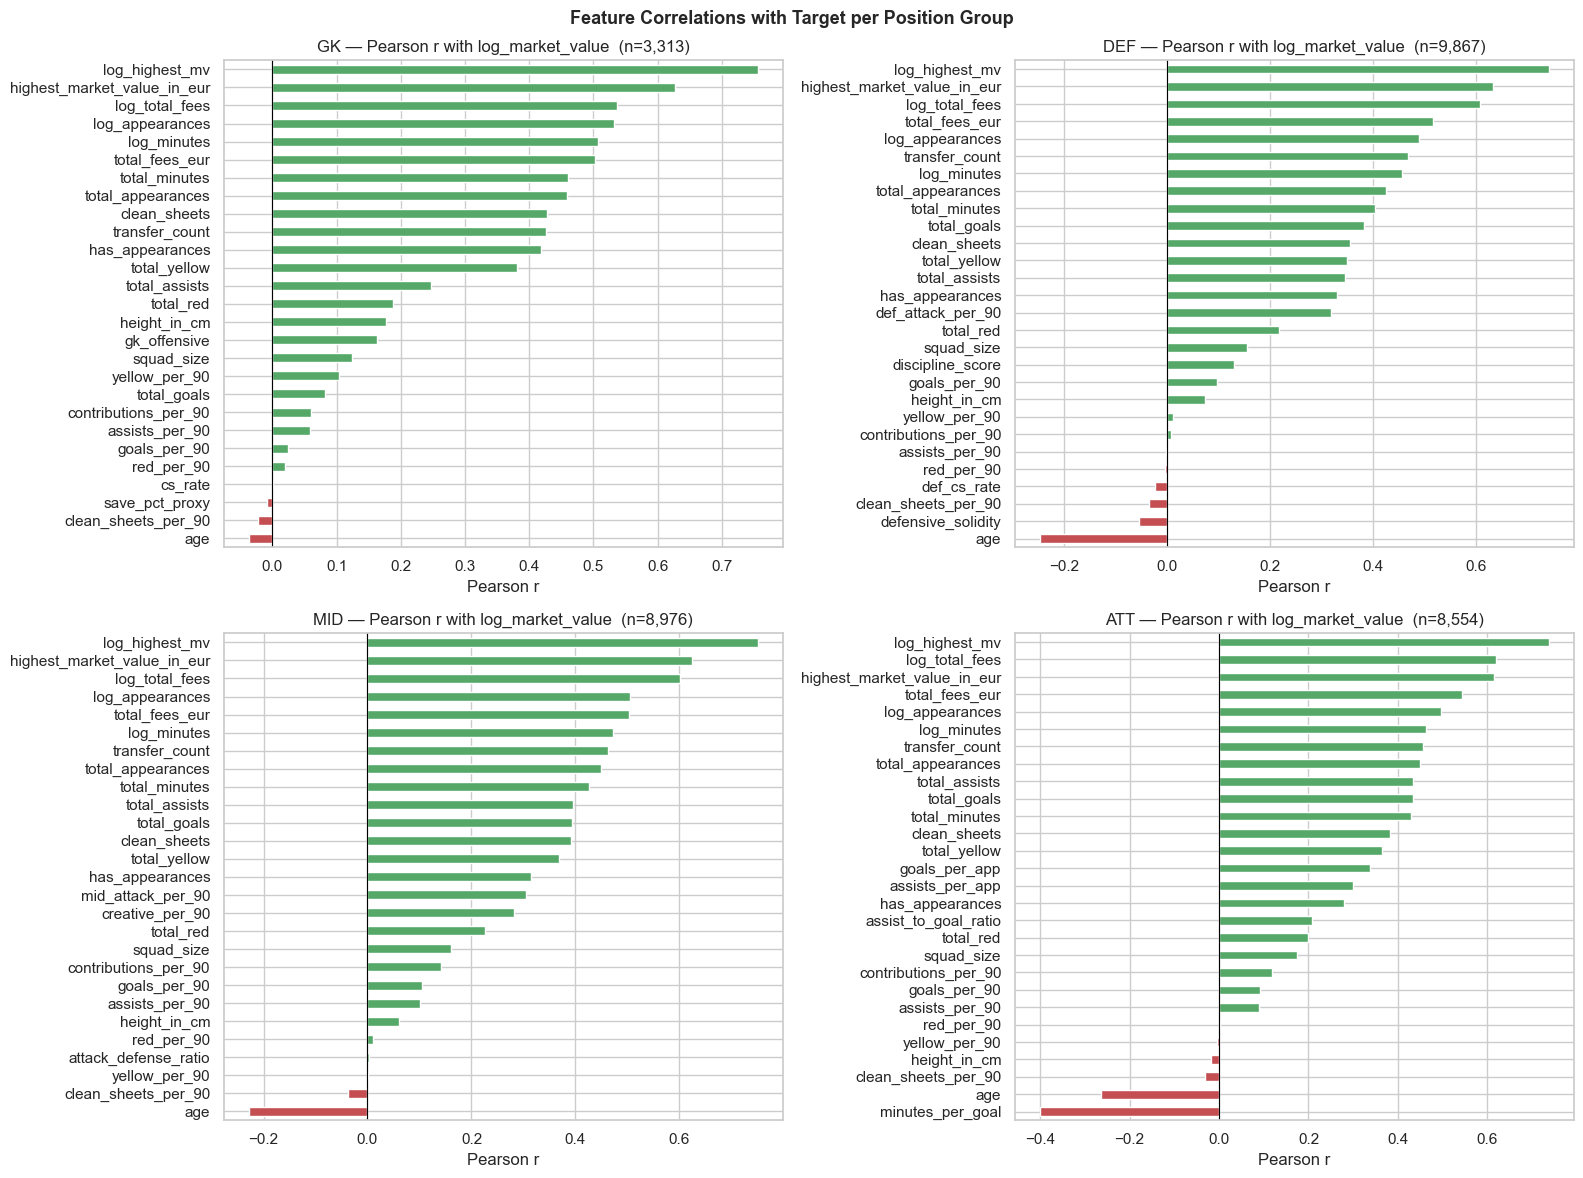


Top 5 features per position group:
  GK: ['log_highest_mv', 'highest_market_value_in_eur', 'log_total_fees', 'log_appearances', 'log_minutes']
  DEF: ['log_highest_mv', 'highest_market_value_in_eur', 'log_total_fees', 'total_fees_eur', 'log_appearances']
  MID: ['log_highest_mv', 'highest_market_value_in_eur', 'log_total_fees', 'log_appearances', 'total_fees_eur']
  ATT: ['log_highest_mv', 'log_total_fees', 'highest_market_value_in_eur', 'total_fees_eur', 'log_appearances']


In [20]:
# Correlation of all numeric features with log_market_value, per position group
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

corr_results = {}
for ax, (label, df) in zip(axes.flatten(),
                            [('GK', df_gk), ('DEF', df_def), ('MID', df_mid), ('ATT', df_att)]):
    d = df.dropna(subset=['log_market_value'])
    numeric = d.select_dtypes(include=[np.number]).columns
    to_corr = [c for c in numeric if c not in SKIP_COLS | {'age_squared'}]

    corr = d[to_corr + ['log_market_value']].corr()['log_market_value'].drop('log_market_value')
    corr = corr.dropna().sort_values()
    corr_results[label] = corr

    colors = ['#C44E52' if v < 0 else '#55A868' for v in corr.values]
    corr.plot(kind='barh', ax=ax, color=colors)
    ax.set_title(f'{label} — Pearson r with log_market_value  (n={len(d):,})')
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel('Pearson r')

plt.suptitle('Feature Correlations with Target per Position Group', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '04_feature_correlations.png')
plt.show()

print('\nTop 5 features per position group:')
for label, corr in corr_results.items():
    top = corr.abs().sort_values(ascending=False).head(5)
    print(f'  {label}: {list(top.index)}')

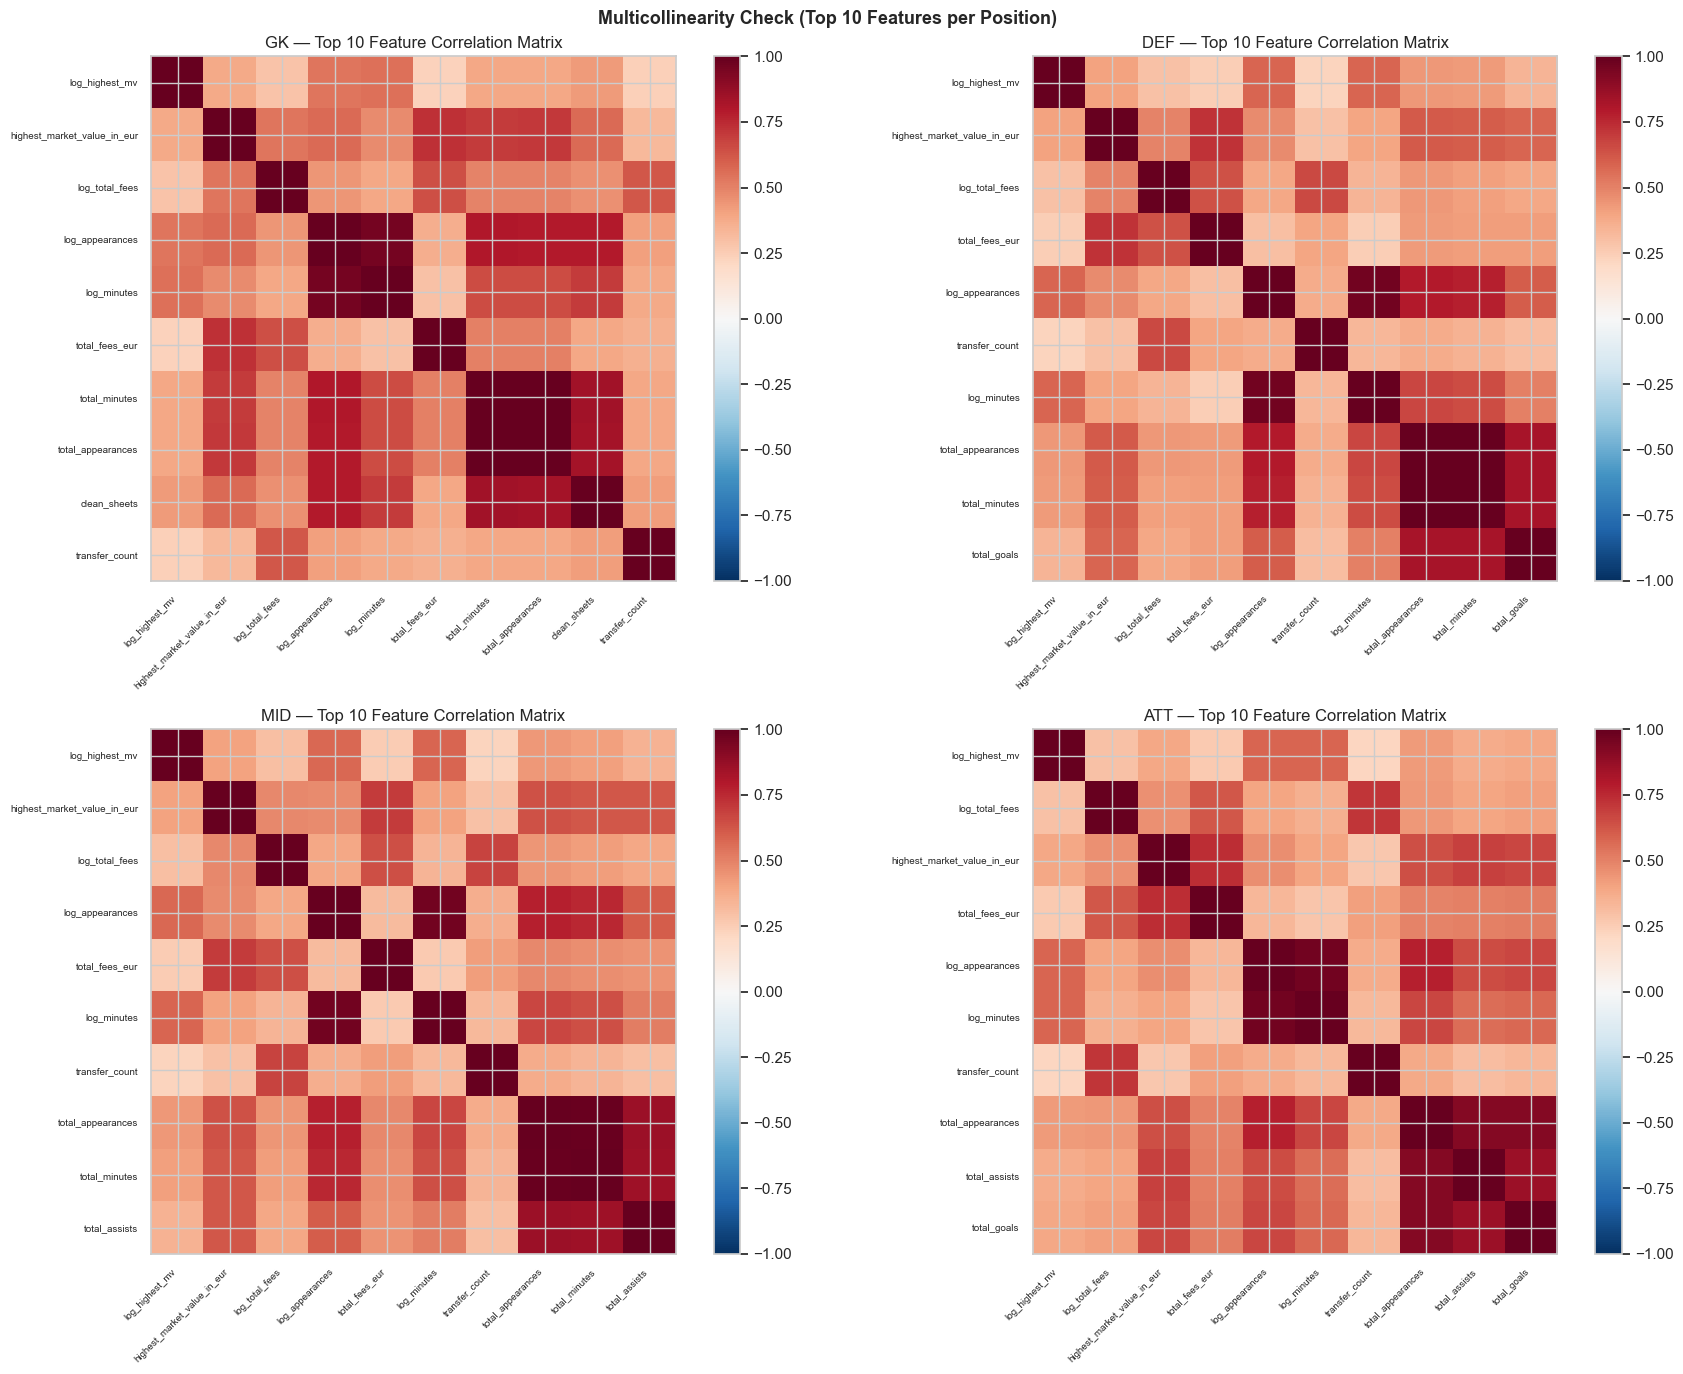

Highly correlated pairs (|r| > 0.9) — consider dropping one in notebook 05:
  GK: log_appearances ↔ log_minutes  (r=0.96)
  GK: total_minutes ↔ total_appearances  (r=1.00)
  DEF: log_appearances ↔ log_minutes  (r=0.96)
  DEF: total_appearances ↔ total_minutes  (r=0.99)
  MID: log_appearances ↔ log_minutes  (r=0.97)
  MID: total_appearances ↔ total_minutes  (r=0.99)
  ATT: log_appearances ↔ log_minutes  (r=0.97)
  ATT: total_appearances ↔ total_assists  (r=0.92)
  ATT: total_appearances ↔ total_goals  (r=0.92)


In [21]:
# Multicollinearity check: correlation heatmap of top 10 features per position
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

for ax, (label, df, corr) in zip(axes.flatten(),
    [('GK',  df_gk,  corr_results['GK']),
     ('DEF', df_def, corr_results['DEF']),
     ('MID', df_mid, corr_results['MID']),
     ('ATT', df_att, corr_results['ATT'])]):

    top10 = corr.abs().sort_values(ascending=False).head(10).index.tolist()
    cm = df[top10].corr()

    im = ax.imshow(cm, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_xticks(range(len(top10)))
    ax.set_yticks(range(len(top10)))
    ax.set_xticklabels(top10, rotation=45, ha='right', fontsize=7)
    ax.set_yticklabels(top10, fontsize=7)
    ax.set_title(f'{label} — Top 10 Feature Correlation Matrix')
    plt.colorbar(im, ax=ax)

plt.suptitle('Multicollinearity Check (Top 10 Features per Position)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '04_multicollinearity.png')
plt.show()

# Flag highly correlated pairs (|r| > 0.9) — candidates for dropping in notebook 05
print('Highly correlated pairs (|r| > 0.9) — consider dropping one in notebook 05:')
for label, df, corr in [('GK',  df_gk,  corr_results['GK']),
                         ('DEF', df_def, corr_results['DEF']),
                         ('MID', df_mid, corr_results['MID']),
                         ('ATT', df_att, corr_results['ATT'])]:
    top10 = corr.abs().sort_values(ascending=False).head(10).index.tolist()
    cm = df[top10].corr().abs()
    pairs = [(top10[i], top10[j], cm.iloc[i,j])
             for i in range(len(top10)) for j in range(i+1, len(top10))
             if cm.iloc[i,j] > 0.9]
    if pairs:
        for a, b, r in pairs:
            print(f'  {label}: {a} ↔ {b}  (r={r:.2f})')
    else:
        print(f'  {label}: no pairs above 0.9')

## 9. Define Feature Sets

In [24]:
# Base features shared by all positions
BASE = [
    'age', 'age_squared',
    'log_minutes', 'log_appearances', 'has_appearances',
    'goals_per_90', 'assists_per_90', 'contributions_per_90',
    'yellow_per_90', 'clean_sheets_per_90',
    'log_highest_mv', 'log_total_fees', 'transfer_count',
    'squad_size',
    'current_club_domestic_competition_id',   # categorical — encoded in notebook 05
]

FEATURE_SETS = {
    'GK':  BASE + ['cs_rate', 'save_pct_proxy', 'gk_offensive'],
    'DEF': BASE + ['def_cs_rate', 'defensive_solidity', 'def_attack_per_90', 'discipline_score'],
    'MID': BASE + ['creative_per_90', 'mid_attack_per_90', 'attack_defense_ratio'],
    'ATT': BASE + ['goals_per_app', 'assists_per_app', 'minutes_per_goal', 'assist_to_goal_ratio'],
}

POS_DFS = {'GK': df_gk, 'DEF': df_def, 'MID': df_mid, 'ATT': df_att}

print('Feature set sizes:')
for pos, feats in FEATURE_SETS.items():
    print(f'  {pos}: {len(feats)} features')
    missing = [f for f in feats
               if f != 'current_club_domestic_competition_id'
               and f not in POS_DFS[pos].columns]
    if missing:
        print(f'    WARNING — missing columns: {missing}')

Feature set sizes:
  GK: 18 features
  DEF: 19 features
  MID: 18 features
  ATT: 19 features


## 10. Save Outputs

In [ ]:
df_gk.to_csv( FEAT_PATH + 'featured_gk.csv',  index=False)
df_def.to_csv(FEAT_PATH + 'featured_def.csv', index=False)
df_mid.to_csv(FEAT_PATH + 'featured_mid.csv', index=False)
df_att.to_csv(FEAT_PATH + 'featured_att.csv', index=False)

with open(PROC_PATH + 'feature_sets.json', 'w') as f:
    json.dump(FEATURE_SETS, f, indent=2)

print(f'Saved featured CSVs → {os.path.abspath(FEAT_PATH)}')
for fname in ['featured_gk.csv', 'featured_def.csv', 'featured_mid.csv', 'featured_att.csv']:
    size = os.path.getsize(FEAT_PATH + fname) / 1024
    print(f'  {fname:<25} {size:>7.1f} KB')
print(f'\nSaved feature_sets.json → {os.path.abspath(PROC_PATH)}')

## 11. Validation

In [ ]:
errors = []

for label, df in [('GK', df_gk), ('DEF', df_def), ('MID', df_mid), ('ATT', df_att)]:
    feats = [f for f in FEATURE_SETS[label] if f != 'current_club_domestic_competition_id']

    # All feature columns exist
    missing = [f for f in feats if f not in df.columns]
    if missing: errors.append(f'{label}: missing features {missing}')
    else: print(f'✓  {label}: all {len(feats)} numeric features present')

    # No NaN in feature columns
    for f in feats:
        n = df[f].isna().sum()
        if n > 0: errors.append(f'{label}.{f}: {n} NaN values')

    # No infinite values
    for f in feats:
        if np.isinf(df[f]).any(): errors.append(f'{label}.{f}: contains inf')

    # log_market_value exists for players with valuation
    n_val = df['market_value_in_eur'].notna().sum()
    n_lmv = df['log_market_value'].notna().sum()
    if n_val != n_lmv: errors.append(f'{label}: valuation/log_market_value count mismatch')
    else: print(f'✓  {label}: {n_val:,} players with log_market_value')

    # No rows lost
    original = pd.read_csv(MERGED_PATH + f'merged_{label.lower()}.csv')
    if len(df) != len(original): errors.append(f'{label}: row count changed {len(original)} → {len(df)}')
    else: print(f'✓  {label}: row count unchanged ({len(df):,})')

print(f"\n{'='*45}")
if errors:
    print(f'FAILED — {len(errors)} issue(s):')
    for e in errors: print(f'  ✗  {e}')
else:
    print('ALL CHECKS PASSED ✓')
    print('Ready for notebook 05 — preprocessing.')
print('='*45)